In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Het inladne van de dataset
df = pd.read_csv("C:/Users/lotte/OneDrive/Master AAI/Hart_opdracht_afstuderen/afstudeeropdracht_lottelampe/Data/data.csv")


In [3]:
# Kolomnaam corrigeren (spaties verwijderen)
df.rename(columns=lambda x: x.strip(), inplace=True)

# Hernoem targetkolom netjes naar target --> dat is wat ik wil gaan voorspellen
df.rename(columns={'num': 'target'}, inplace=True)

# Convert '?' strings naar NaN zodat we ze goed kunnen detecteren
df.replace('?', np.nan, inplace=True)


In [4]:
# Features en target splitsen
X = df.drop('target', axis=1)
y = df['target']

In [5]:
from sklearn.model_selection import train_test_split

# 80% training, 20% test, met stratificatie op de target en vaste random_state voor reproduceerbaarheid
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Train X:", X_train.shape)
print("Test  X:", X_test.shape)


Train X: (235, 13)
Test  X: (59, 13)


- test_size=0.20 houdt 20 % van de data apart voor de testset.
- stratify=y zorgt dat de klasse-verdeling in train en test hetzelfde blijft als in de volledige dataset.
- random_state=42 maakt je splitsing reproduceerbaar.

### EDA

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [7]:
# Samenvoegen voor gemak van de EDA
train = X_train.copy()
train['target'] = y_train

# Vorm en types
print("Shape:", train.shape)
print("\nDtypes:\n", train.dtypes)

# Missing values per kolom
print("\nMissing values:\n", train.isna().sum())


Shape: (235, 14)

Dtypes:
 age           int64
sex           int64
cp            int64
trestbps     object
chol         object
fbs          object
restecg      object
thalach      object
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target        int64
dtype: object

Missing values:
 age           0
sex           0
cp            0
trestbps      1
chol         19
fbs           6
restecg       0
thalach       1
exang         1
oldpeak       0
slope       149
ca          232
thal        209
target        0
dtype: int64


In [8]:
# Numerieke features
print(train.describe())

# Categoriale / ordinale features
print(train[['sex','cp','fbs','restecg','exang']].describe())


              age         sex          cp     oldpeak      target
count  235.000000  235.000000  235.000000  235.000000  235.000000
mean    47.774468    0.719149    3.029787    0.606383    0.361702
std      7.815459    0.450374    0.953606    0.932189    0.481519
min     28.000000    0.000000    1.000000    0.000000    0.000000
25%     42.000000    0.000000    2.000000    0.000000    0.000000
50%     48.000000    1.000000    3.000000    0.000000    0.000000
75%     54.000000    1.000000    4.000000    1.000000    1.000000
max     66.000000    1.000000    4.000000    5.000000    1.000000
              sex          cp
count  235.000000  235.000000
mean     0.719149    3.029787
std      0.450374    0.953606
min      0.000000    1.000000
25%      0.000000    2.000000
50%      1.000000    3.000000
75%      1.000000    4.000000
max      1.000000    4.000000


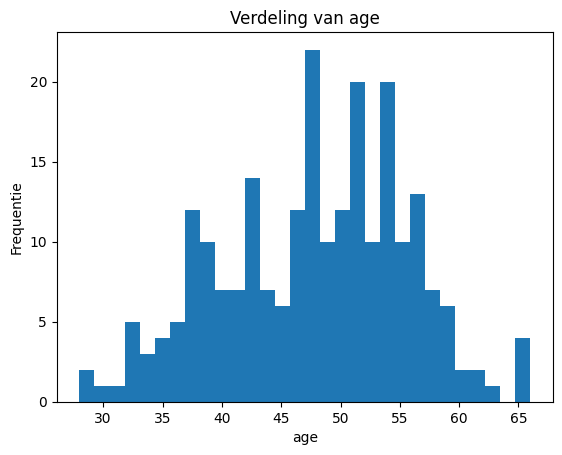

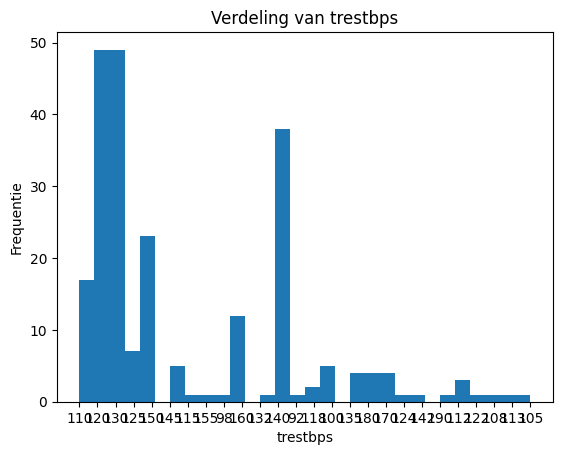

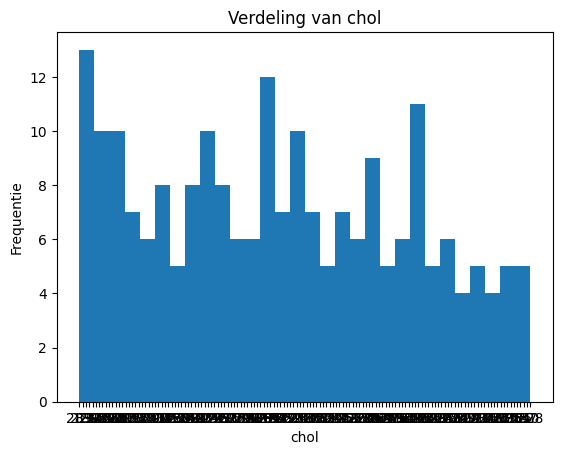

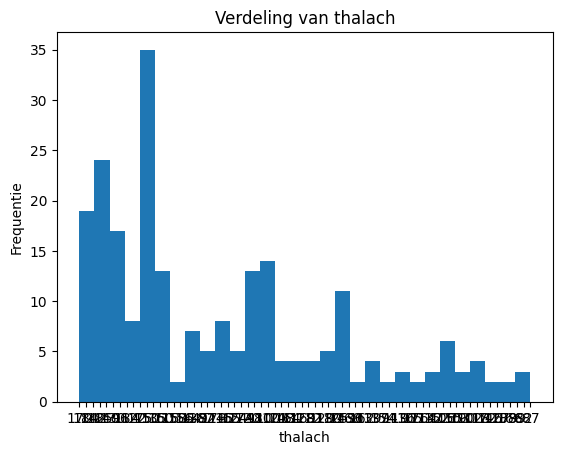

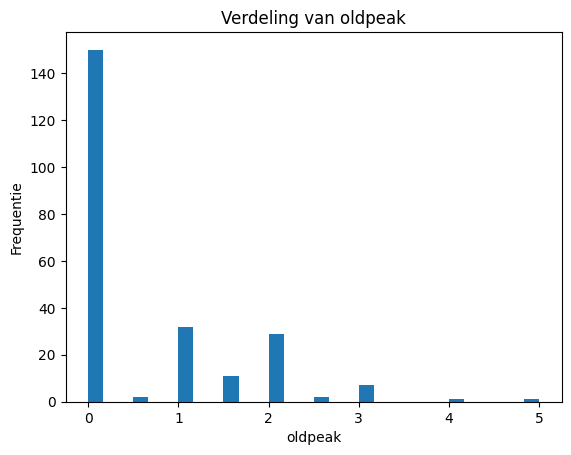

In [9]:
num_cols = ['age','trestbps','chol','thalach','oldpeak']
for col in num_cols:
    plt.figure()
    plt.hist(train[col].dropna(), bins=30)
    plt.title(f'Verdeling van {col}')
    plt.xlabel(col)
    plt.ylabel('Frequentie')
    plt.show()


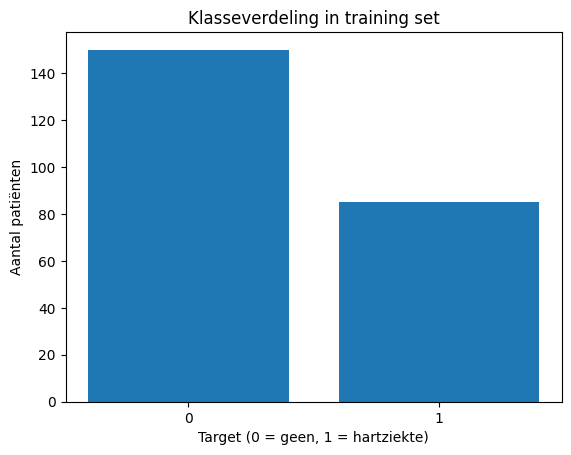

In [10]:
import matplotlib.pyplot as plt

counts = train['target'].value_counts()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Target (0 = geen, 1 = hartziekte)')
plt.ylabel('Aantal patiënten')
plt.title('Klasseverdeling in training set')
plt.show()


In [11]:
# Totale cellen in de dataset
total_values = X_train.shape[0] * X_train.shape[1]

# Aantal missende waarden
total_missing = X_train.isnull().sum().sum()

# Percentage ontbrekend
percent_missing = (total_missing / total_values) * 100

# Per kolom missend 
missing_per_column = X_train.isnull().sum()
missing_columns = missing_per_column[missing_per_column > 0]

# Resultaten printen
print(f" Totaal aantal cellen in X_train: {total_values}")
print(f" Aantal ontbrekende waarden: {total_missing}")
print(f" Percentage ontbrekende data: {percent_missing:.2f}%")

if missing_columns.empty:
    print(" Geen missende waarden in individuele kolommen.")
else:
    print("\n Missende waarden per kolom:")
    print(missing_columns.sort_values(ascending=False))


 Totaal aantal cellen in X_train: 3055
 Aantal ontbrekende waarden: 618
 Percentage ontbrekende data: 20.23%

 Missende waarden per kolom:
ca          232
thal        209
slope       149
chol         19
fbs           6
trestbps      1
thalach       1
exang         1
dtype: int64


In [12]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
198,41,1,4,110,289,0,0,170,0,0.0,NaN,NaN,6
6,32,1,2,110,225,0,0,184,0,0.0,NaN,NaN,NaN
68,44,1,2,120,184,0,0,142,0,1.0,2,NaN,NaN
0,28,1,2,130,132,0,2,185,0,0.0,NaN,NaN,NaN
216,54,1,4,125,216,0,0,140,0,0.0,NaN,NaN,NaN


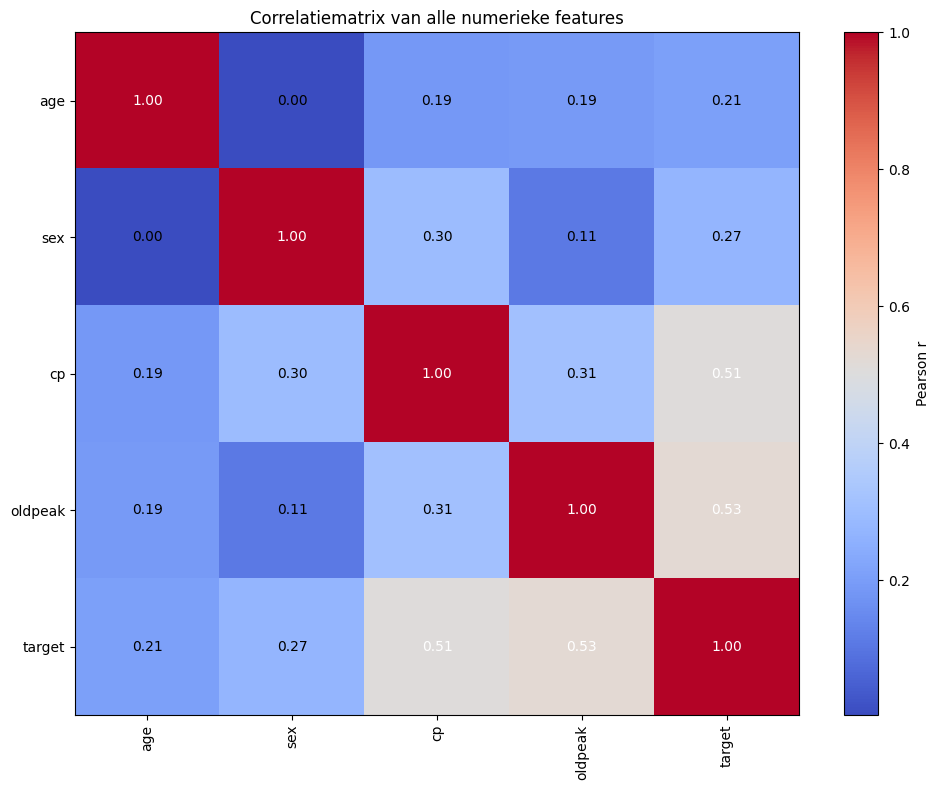

Sterkste correlaties met target:
oldpeak    0.527991
cp         0.506925
sex        0.273368
age        0.209139
Name: target, dtype: float64


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Selecteren alle numerieke kolommen
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# Berekenen van de correlatiematrix
corr = train[num_cols].corr()

# Plotten van de heatmap met annotatie
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label='Pearson r')
ticks = np.arange(len(corr.columns))
plt.xticks(ticks, corr.columns, rotation=90)
plt.yticks(ticks, corr.index)

# Correlatiewaarden
for i in ticks:
    for j in ticks:
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha='center', va='center',
                 color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')

plt.title('Correlatiematrix van alle numerieke features')
plt.tight_layout()
plt.show()

abs_corr_with_target = corr['target'].abs().sort_values(ascending=False)
print("Sterkste correlaties met target:")
print(abs_corr_with_target[1:6])


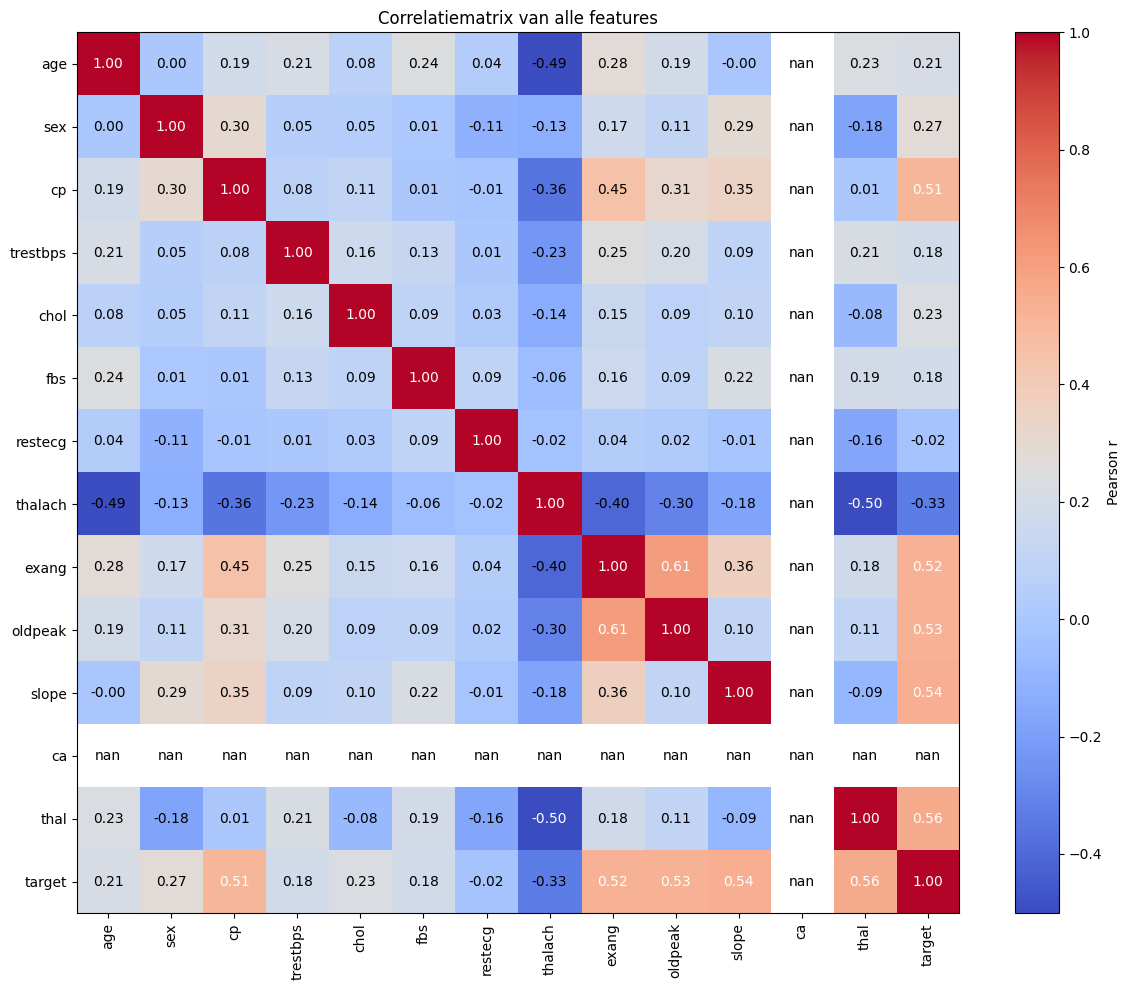

Top 5 correlaties met target:
thal       0.556794
slope      0.538895
oldpeak    0.527991
exang      0.524902
cp         0.506925
Name: target, dtype: float64


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_train = X_train.copy()
df_train['target'] = y_train

# Elke kolom omzetten naar numeriek (fouten → NaN)
df_train = df_train.apply(pd.to_numeric, errors='coerce')

# Berekenen correlatiematrix
corr = df_train.corr()

# Heatmap met annotaties
plt.figure(figsize=(12,10))
plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label='Pearson r')
ticks = np.arange(len(corr.columns))
plt.xticks(ticks, corr.columns, rotation=90)
plt.yticks(ticks, corr.index)

# Overlay waarden 
for i in ticks:
    for j in ticks:
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha='center', va='center',
                 color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')

plt.title('Correlatiematrix van alle features')
plt.tight_layout()
plt.show()

# Printen van de 5 sterkste correlaties met target
abs_corr = corr['target'].abs().sort_values(ascending=False)
print("Top 5 correlaties met target:")
print(abs_corr[1:6])


<Figure size 640x480 with 0 Axes>

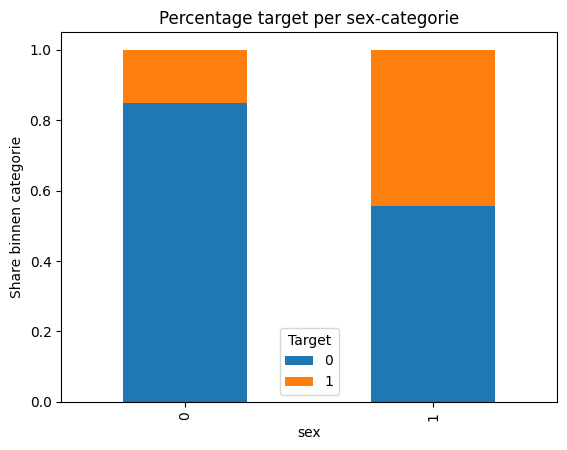

<Figure size 640x480 with 0 Axes>

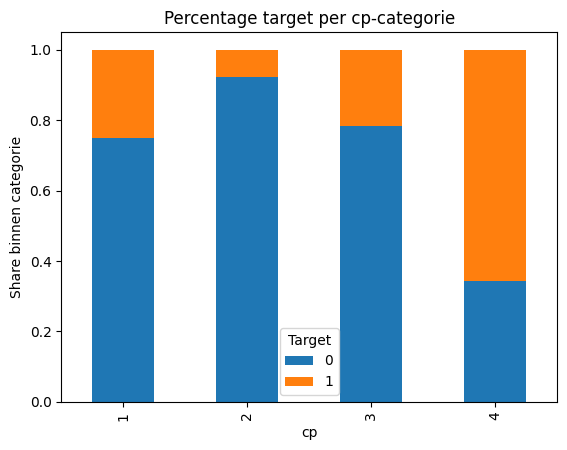

<Figure size 640x480 with 0 Axes>

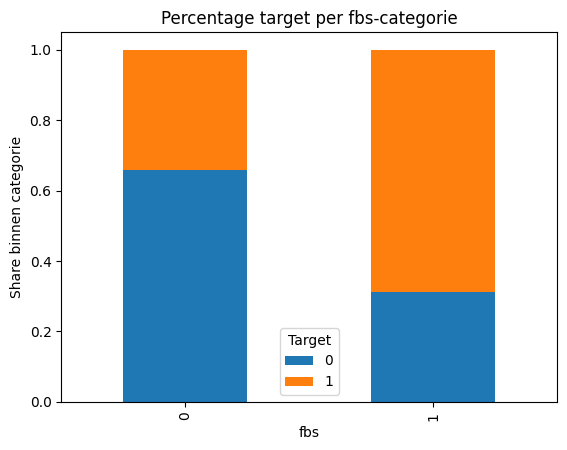

<Figure size 640x480 with 0 Axes>

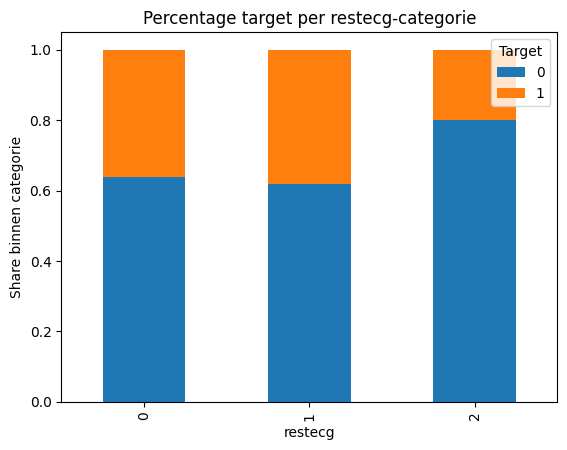

<Figure size 640x480 with 0 Axes>

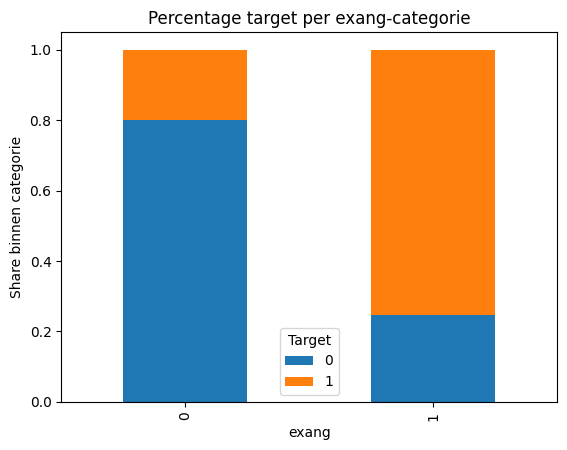

In [15]:
cat_cols = ['sex','cp','fbs','restecg','exang']
for col in cat_cols:
    plt.figure()
    pd.crosstab(train[col], train['target'], normalize='index').plot.bar(stacked=True)
    plt.title(f'Percentage target per {col}-categorie')
    plt.ylabel('Share binnen categorie')
    plt.xlabel(col)
    plt.legend(title='Target')
    plt.show()


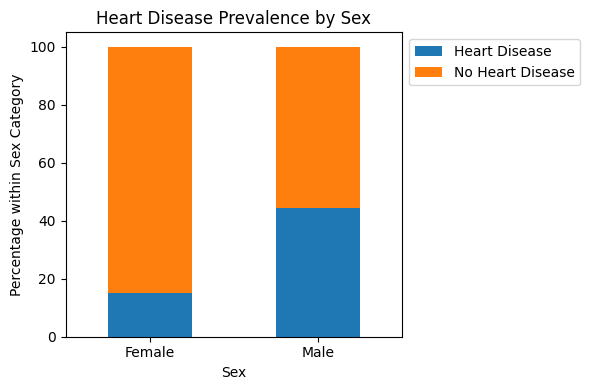

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df_plot = df_train.copy()

df_plot['sex'] = df_plot['sex'].map({0: 'Female', 1: 'Male'})
df_plot['target'] = df_plot['target'].map({0: 'No Heart Disease', 1: 'Heart Disease'})

pct = (
    df_plot
    .groupby('sex')['target']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
)

pivot = pct.pivot(index='sex', columns='target', values='percentage')


ax = pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(6,4)
)

ax.set_ylabel('Percentage within Sex Category')
ax.set_xlabel('Sex')
ax.set_title('Heart Disease Prevalence by Sex')
ax.legend(title='', bbox_to_anchor=(1,1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [17]:
# Outlier detectie (IQR-method)
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers")

age: 0 outliers
sex: 0 outliers
cp: 0 outliers
oldpeak: 11 outliers
target: 0 outliers


     feature     shapiro_p  normal?
0        age  8.291624e-03    False
1        sex  6.276828e-24    False
2         cp  5.234352e-17    False
3   trestbps  3.004711e-06    False
4       chol  7.175342e-09    False
5        fbs  5.084802e-29    False
6    restecg  4.271324e-25    False
7    thalach  2.814005e-02    False
8      exang  1.179109e-23    False
9    oldpeak  1.620791e-20    False
10     slope  1.682839e-16    False
11        ca  1.000000e+00     True
12      thal  1.240972e-05    False
13    target  8.016661e-23    False


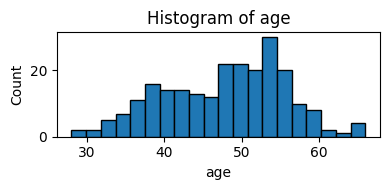

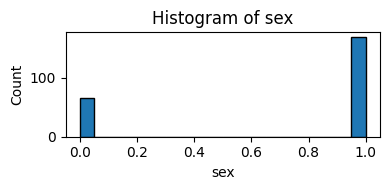

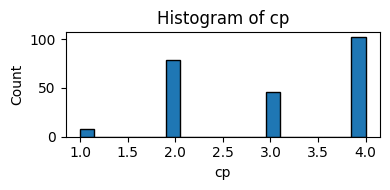

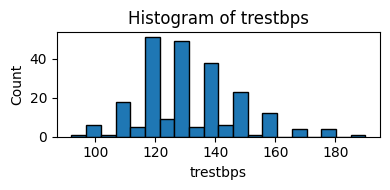

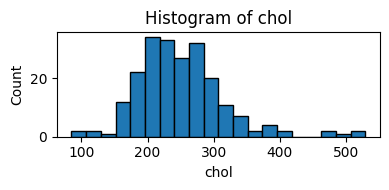

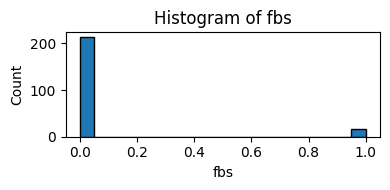

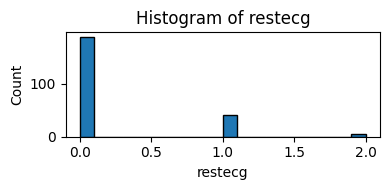

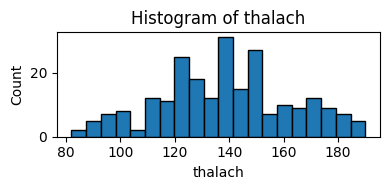

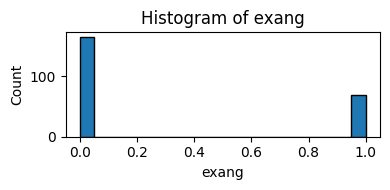

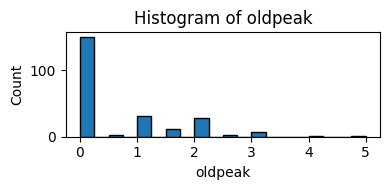

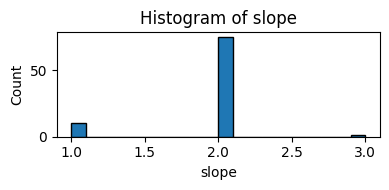

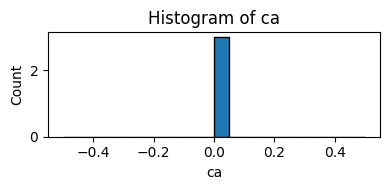

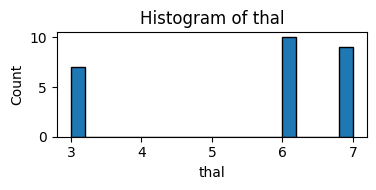

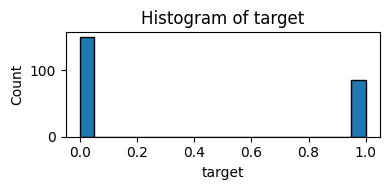

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Selecteren van alle numerieke kolommen
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Normaliteitstest per feature 
normality = []
for col in num_cols:
    data = df_train[col].dropna()
    if len(data) >= 3:
        stat, p = stats.shapiro(data)
    else:
        p = np.nan  # te weinig data om te testen
    normality.append((col, p))

# Resultaten in een DataFrame
norm_df = pd.DataFrame(normality, columns=['feature', 'shapiro_p'])
norm_df['normal?'] = norm_df['shapiro_p'] > 0.05
print(norm_df)

# histogrammen per feature
for col in num_cols:
    plt.figure(figsize=(4,2))
    plt.hist(df_train[col].dropna(), bins=20, edgecolor='k')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


### Preprocessen

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib

In [20]:
# Droppen ivm teveel missende waarden
cols_to_drop = ['slope', 'ca', 'thal']

X_train = X_train.drop(columns=cols_to_drop)
X_test  = X_test.drop(columns=cols_to_drop)

print("Nieuw shape X_train:", X_train.shape)
print("Nieuw shape X_test: ", X_test.shape)


Nieuw shape X_train: (235, 10)
Nieuw shape X_test:  (59, 10)


In [21]:
# imputatie instellen (voor invullen van missende waarden)
num_cols = ['age','trestbps','chol','thalach','oldpeak']
cat_cols = ['sex','cp','fbs','restecg','exang']

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

> Waarom
Numerieke features (age, trestbps, … → mediaan)
- Deze variabelen zijn écht continue getallen, waar een lege plek gevuld moet worden met een representatieve centrale waarde.
- De mediaan is hier het beste, omdat hij ongevoelig is voor uitschieters.

Categorische features (sex, cp, fbs, restecg, exang → modus)
- Dit zijn labels, ook al zijn ze gecodeerd als cijfers. Het is geen rekenkundig verschil “4 – 2 = 2”, maar een aparte categorie “type 4 borstpijn”.
- De modus vult een lege plek op met de meest voorkomende categorie, en behoudt zo de oorspronkelijke klassenverdeling.

In [22]:
# Numeriek imputeren
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols]  = num_imputer.transform(X_test[num_cols])

# Categoraal imputeren
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
X_test[cat_cols]  = cat_imputer.transform(X_test[cat_cols])

In [23]:
# Samenvoegen voor gemak
train = X_train.copy()
train['target'] = y_train

# Vorm en types
print("Shape:", train.shape)
print("\nDtypes:\n", train.dtypes)

# Missing values per kolom
print("\nMissing values:\n", train.isna().sum())


Shape: (235, 11)

Dtypes:
 age         float64
sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalach     float64
exang        object
oldpeak     float64
target        int64
dtype: object

Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
target      0
dtype: int64


> geen NaN waarden meer


> wel object aanwezig

In [24]:
# Vind de object-kolommen
object_cols = X_train.select_dtypes(include=['object']).columns

# Inspecteren per kolom
for col in object_cols:
    print(f"\n=== Kolom: {col} (dtype={X_train[col].dtype}) ===")
    
    # Eerste vijf waarden
    print("Head:")
    print(X_train[col].head().to_list())
    
    # Unieke waarden en hun frequentie
    print("\nValue counts:")
    print(X_train[col].value_counts(dropna=False).to_dict())
    
    # Welke Python-types er echt in de Series zitten
    types = X_train[col].map(type).value_counts()
    print("\nOnderliggende Python-types:")
    print(types.to_dict())



=== Kolom: sex (dtype=object) ===
Head:
[1, 1, 1, 1, 1]

Value counts:
{1: 169, 0: 66}

Onderliggende Python-types:
{<class 'int'>: 235}

=== Kolom: cp (dtype=object) ===
Head:
[4, 2, 2, 2, 4]

Value counts:
{4: 102, 2: 79, 3: 46, 1: 8}

Onderliggende Python-types:
{<class 'int'>: 235}

=== Kolom: fbs (dtype=object) ===
Head:
['0', '0', '0', '0', '0']

Value counts:
{'0': 219, '1': 16}

Onderliggende Python-types:
{<class 'str'>: 235}

=== Kolom: restecg (dtype=object) ===
Head:
['0', '0', '0', '2', '0']

Value counts:
{'0': 188, '1': 42, '2': 5}

Onderliggende Python-types:
{<class 'str'>: 235}

=== Kolom: exang (dtype=object) ===
Head:
['0', '0', '0', '0', '0']

Value counts:
{'0': 166, '1': 69}

Onderliggende Python-types:
{<class 'str'>: 235}


> waarom object:

Één of meer niet-numerieke waarden (zoals "?") ooit in de kolom hebben gestaan, waardoor pandas de hele kolom als object heeft opgeslagen, zelfs als je die later met numerieke waarden vervangt.

In [25]:
# One-hot encoding van nominale kolommen 
X_train = pd.get_dummies(
    X_train,
    columns=['cp','restecg'],       
    prefix=['cp','restecg'],
                  
)
X_test  = pd.get_dummies(
    X_test,
    columns=['cp','restecg'],
    prefix=['cp','restecg'],
    
)
# Zorgen dat test exact dezelfde kolommen heeft als train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [26]:
# Forceren van alle object-kolommen naar numeriek
object_cols = X_train.select_dtypes(include=['object']).columns
for col in object_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='raise')
    X_test[col]  = pd.to_numeric(X_test[col],  errors='raise')

> wat er veranderd: 
- Wel: de dtype van de kolom verandert van object naar int64 of float64.
- Niet: de waarden zelf (bijv. 0, 1, 150) blijven hetzelfde, alleen nu écht als getal opgeslagen.

In [27]:
# Samenvoegen voor gemak
train = X_train.copy()
train['target'] = y_train

# Vorm en types
print("Shape:", train.shape)
print("\nDtypes:\n", train.dtypes)

# Missing values per kolom
print("\nMissing values:\n", train.isna().sum())


Shape: (235, 16)

Dtypes:
 age          float64
sex            int64
trestbps     float64
chol         float64
fbs            int64
thalach      float64
exang          int64
oldpeak      float64
cp_1            bool
cp_2            bool
cp_3            bool
cp_4            bool
restecg_0       bool
restecg_1       bool
restecg_2       bool
target         int64
dtype: object

Missing values:
 age          0
sex          0
trestbps     0
chol         0
fbs          0
thalach      0
exang        0
oldpeak      0
cp_1         0
cp_2         0
cp_3         0
cp_4         0
restecg_0    0
restecg_1    0
restecg_2    0
target       0
dtype: int64


> Geen objecten meer aanwezig

In [28]:
# Schalen met StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [29]:
print("Shapes:", X_train_scaled.shape, X_test_scaled.shape)

Shapes: (235, 15) (59, 15)


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'trestbps'}>,
        <Axes: title={'center': 'chol'}>],
       [<Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'thalach'}>,
        <Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>],
       [<Axes: title={'center': 'cp_1'}>,
        <Axes: title={'center': 'cp_2'}>,
        <Axes: title={'center': 'cp_3'}>,
        <Axes: title={'center': 'cp_4'}>],
       [<Axes: title={'center': 'restecg_0'}>,
        <Axes: title={'center': 'restecg_1'}>,
        <Axes: title={'center': 'restecg_2'}>, <Axes: >]], dtype=object)

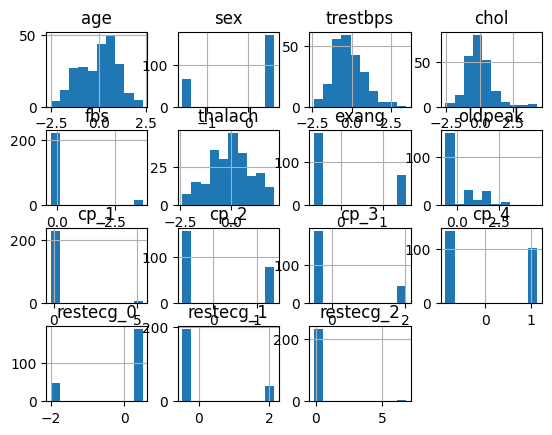

In [30]:
X_train_scaled.hist()

In [31]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 198 to 69
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        235 non-null    float64
 1   sex        235 non-null    float64
 2   trestbps   235 non-null    float64
 3   chol       235 non-null    float64
 4   fbs        235 non-null    float64
 5   thalach    235 non-null    float64
 6   exang      235 non-null    float64
 7   oldpeak    235 non-null    float64
 8   cp_1       235 non-null    float64
 9   cp_2       235 non-null    float64
 10  cp_3       235 non-null    float64
 11  cp_4       235 non-null    float64
 12  restecg_0  235 non-null    float64
 13  restecg_1  235 non-null    float64
 14  restecg_2  235 non-null    float64
dtypes: float64(15)
memory usage: 29.4 KB


In [32]:
# Opslaan van de scaler
joblib.dump(scaler, 'standard_onscaler.pkl')


['standard_onscaler.pkl']

In [33]:
# 2) Opslaan als pickle (voor later exact herladen)
X_train.to_pickle('X_ontrain.pkl')
X_test.to_pickle('X_ontest.pkl')
y_train.to_pickle('y_ontrain.pkl')
y_test.to_pickle('y_ontest.pkl')

X_train_scaled.to_pickle('X_ontrain_scaled.pkl')
X_test_scaled.to_pickle('X_ontest_scaled.pkl')

In [34]:
# # pickle
# X_train = pd.read_pickle('X_train.pkl')

### Baseline Modellen Vergelijken

In [35]:
import pandas as pd
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Modellen definiëren (vanuit sklearn en literatuur)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'KNN':                KNeighborsClassifier(),
    'DecisionTree':       DecisionTreeClassifier(random_state=42),
    'RandomForest':       RandomForestClassifier(random_state=42),
    'GradientBoosting':   GradientBoostingClassifier(random_state=42),
    'LinearSVC':          LinearSVC(class_weight='balanced', max_iter=10000, random_state=42),
    'SVC':                SVC(probability=True, random_state=42)
}

# CV-strategie
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics en resultatenlijst
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
results = []

for name, model in models.items():
    # Cross-validate voor gemiddelden
    scores = cross_validate(model, X_train_scaled, y_train, cv=cv,
                            scoring=scoring, return_train_score=False)
    
    # CV-voorspellingen voor confusion matrix
    y_pred_cv = cross_val_predict(model, X_train_scaled, y_train, cv=cv)
    cm = confusion_matrix(y_train, y_pred_cv)
    tn, fp, fn, tp = cm.ravel()
    
    # Classification report als dict
    report = classification_report(y_train, y_pred_cv, output_dict=True)
    
    # Verzamelen alle metrics
    results.append({
        'Model':             name,
        'ROC AUC Mean':      scores['test_roc_auc'].mean(),
        'ROC AUC Std':       scores['test_roc_auc'].std(),
        'Accuracy Mean':     scores['test_accuracy'].mean(),
        'Accuracy Std':      scores['test_accuracy'].std(),
        'Precision Mean':    scores['test_precision'].mean(),
        'Precision Std':     scores['test_precision'].std(),
        'Recall Mean':       scores['test_recall'].mean(),
        'Recall Std':        scores['test_recall'].std(),
        'F1 Mean':           scores['test_f1'].mean(),
        'F1 Std':            scores['test_f1'].std(),
        'TN':                tn,
        'FP':                fp,
        'FN':                fn,
        'TP':                tp,
        'CV Recall (pos)':   report['1']['recall'],
        'CV Precision (pos)':report['1']['precision']
    })

# omzetten naar DataFrame en sorteren
results_df = pd.DataFrame(results).sort_values(
    by='ROC AUC Mean', ascending=False
).reset_index(drop=True)

print(results_df)

# Per model de confusion matrix en report nog eens duidelijk printen
for name, model in models.items():
    y_pred_cv = cross_val_predict(model, X_train_scaled, y_train, cv=cv)
    print(f"\n{name} CV Confusion Matrix (TN, FP, FN, TP):")
    print(confusion_matrix(y_train, y_pred_cv).ravel())
    print(classification_report(y_train, y_pred_cv, target_names=['Geen HVZ','HVZ']))


                Model  ROC AUC Mean  ROC AUC Std  Accuracy Mean  Accuracy Std  \
0  LogisticRegression      0.885882     0.046108       0.791489      0.045434   
1           LinearSVC      0.884314     0.046018       0.787234      0.038061   
2        RandomForest      0.879608     0.029382       0.787234      0.013457   
3                 SVC      0.874118     0.041435       0.808511      0.026913   
4                 KNN      0.848824     0.029145       0.782979      0.031270   
5    GradientBoosting      0.846275     0.033771       0.782979      0.031270   
6        DecisionTree      0.722745     0.055872       0.740426      0.041257   

   Precision Mean  Precision Std  Recall Mean  Recall Std   F1 Mean    F1 Std  \
0        0.701905       0.062223     0.741176    0.121125  0.716200  0.076259   
1        0.698462       0.059860     0.741176    0.121125  0.712105  0.065390   
2        0.769788       0.077984     0.611765    0.079792  0.673018  0.031396   
3        0.806680       0.0

### Beste model opslaan

In [36]:
import joblib
from sklearn.linear_model import LogisticRegression

# Trainen van het beste model 
best_lr = LogisticRegression(
    class_weight='balanced',
    C=1.0,              
    max_iter=1000,
    random_state=42
)
best_lr.fit(X_train_scaled, y_train)

# Opslaan van het model
joblib.dump(best_lr, 'nlogistic_regression_model.pkl')

print("Model opgeslagen als 'nlogistic_regression_model.pkl'")


Model opgeslagen als 'nlogistic_regression_model.pkl'


In [37]:
# Inladen
# loaded_lr = joblib.load('logistic_regression_model.pkl')

# Direct gebruiken om te voorspellen
# y_pred = loaded_lr.predict(X_test_scaled)
